**Import Packages**

In [1]:
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn
sns.set(rc={'figure.figsize':(10,6)})
tips = sns.load_dataset("tips")
from imblearn.over_sampling import SMOTE, KMeansSMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

**Reading data**

In [2]:
#enriched data
df = pd.read_csv("fake_job_postings.csv") # emscad dataset
#scraped data
df_scraped = pd.read_csv("scraped_data.csv") # scraped data from craiglist

In [3]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


**Data Preparation**

In [4]:
#filter jobs from United States
def preprocess(df):
    '''This function takes dataframe as input
    and returns a processed dataframe'''
    df = df[df.location.notnull()]
    df= df[df.location.str.contains("US,")] 
    return df

df = preprocess(df) 

In [5]:
#join scraped data and enriched dataset
df = df[['description', 'fraudulent']]
df_scraped = df_scraped[['description', 'fraudulent']]

df = pd.concat([df, df_scraped])

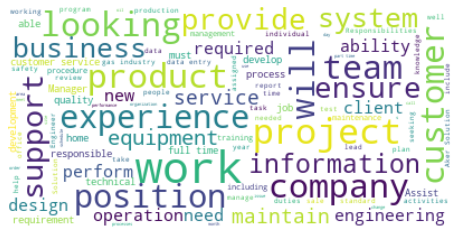

In [6]:
#Undertand most frequent words in a fraud job listing
df_Fraud = df[df['fraudulent']==1]
list_of_tokens= ''
for tok in df_Fraud['description']:
    token_1 = nltk.word_tokenize(tok)
    list_of_tokens = list_of_tokens+ ' '.join(token_1)

#generate wordcloud of frequest words on fraud job listings
wordcloud = WordCloud(stopwords=STOPWORDS, max_font_size=40, max_words=100, background_color="white").generate(list_of_tokens)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

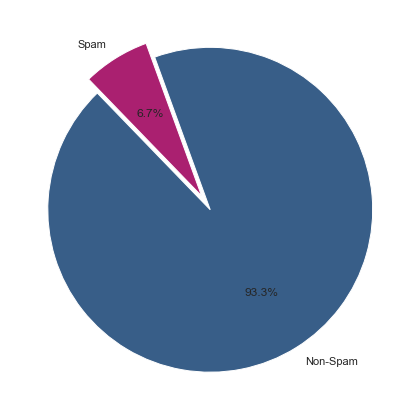

In [7]:
#Undertand Class Distribution
def pie_spam(list_spam):
    count_spam = 0
    for i in list_spam:
        if i == 1:
            count_spam += 1
        else:
            pass
    count_Non_spam = len(list_spam) - count_spam
    fig_data = [count_spam, count_Non_spam]
    fig_label = ["Spam", "Non-Spam"]
    fig_explode = [0.1, 0]
    fig_color = ['#AA2070','#385E88']
    fig1, ax1 = plt.subplots()
    ax1.pie(fig_data, labels=fig_label, colors=fig_color,  explode=fig_explode, autopct='%1.1f%%', startangle=110)
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"spam_pie.png")
    
isSpam=df.fraudulent.tolist()
pie_spam(isSpam)

In [8]:
#appply nlp data preparation techniques like tokenization, stemming, removing stop words
def text_preprocess(document):
    stemmer = WordNetLemmatizer() 
    document = document.lower()
    words = nltk.word_tokenize(document)                                         #tokenization
    words = [stemmer.lemmatize(word) for word in words if word.isalpha()]        #stemming
    words = [word for word in words if word not in stopwords.words("english")]   #stop words removal
    sentence = " ".join(words)
    return sentence

textList = [str(text) for text in df.description]
processed_data_text = [text_preprocess(text) for text in textList]
df_text = pd.DataFrame({'label': isSpam , 'description': processed_data_text})
df_text

,label,description
0,0,james beard online food community curated reci...
1,0,client located houston actively seeking experi...
2,0,company esri environmental system research ins...
3,0,job title itemization review managerlocation f...
4,0,job overviewapex environmental consulting firm...
...,...,...
11787,0,la vega premier window cleaning company immedi...
11788,0,cedco masonry looking experienced mason helper...
11789,0,local construction company hiring flat bed dri...
11790,0,steel hiring welder helper construction experi...


In [9]:
#create a dummy tokenizer
def tokenizer(doc):
    return doc

#SMOTE oversample
def smote(train_x, train_y):
    '''This function takes input features and target variables as input 
       and returns oversampled inout and target features'''
    smt = KMeansSMOTE(random_state=42, k_neighbors = 72, cluster_balance_threshold = 0.05)
    train_x,train_y = smt.fit_resample(train_x,train_y)
    return train_x,train_y

#tf-idf vectorizer
vec = TfidfVectorizer(analyzer='word', tokenizer=tokenizer, preprocessor=tokenizer, token_pattern=None,
                      min_df=2, ngram_range=(1,2), stop_words='english')
vec.fit(df_text.description)

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                preprocessor=<function tokenizer at 0x7fc3a984a3a0>,
                stop_words='english', token_pattern=None,
                tokenizer=<function tokenizer at 0x7fc3a984a3a0>)

**Train Test Split**

In [10]:
#Split data into train and test for model evaluation
train_x, test_x, train_y, test_y = train_test_split(df_text.description, df_text.label, test_size=0.2, random_state=0)

#transform raw data into tfidf vectors
train_x = vec.transform(train_x)
test_x = vec.transform(test_x)

#oversample the dataset
train_x,train_y = smote(train_x,train_y)

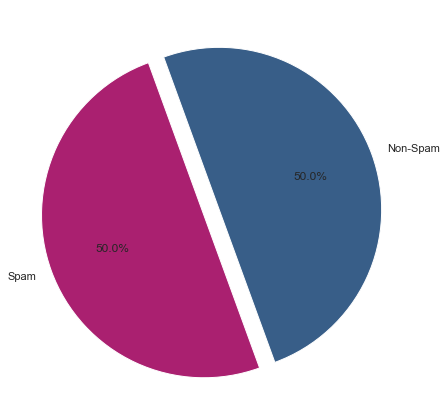

In [11]:
#understand target class distribution after oversampling
pie_spam(train_y)

**Modelling & Evaluation**

In [12]:
modelList = ['Naive Bayes', 'Random Forest', 'Linear SVM', 'Logistic Regression', 'Gradient Boosting'] #list of models to be tested
accuracyList = []     #to store accuracy of each model
f1List = []           #to store f1 score of each model

In [13]:
#Naive Bayes Model
def naiveb(train_x, train_y, test_x, test_y):
    model = BernoulliNB()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Naive Bayes:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred ), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = naiveb(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Naive Bayes:::
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2183
           1       0.10      0.26      0.14       176

    accuracy                           0.77      2359
   macro avg       0.51      0.53      0.50      2359
weighted avg       0.87      0.77      0.81      2359



In [14]:
#Random Forest Model
def rfmodel(train_x, train_y, test_x, test_y):
    model = RandomForestClassifier(n_estimators=500, max_depth=6, bootstrap=True, random_state=0,class_weight = 'balanced')
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Random Forestl:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred,), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = rfmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Random Forestl:::
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2183
           1       0.62      0.26      0.36       176

    accuracy                           0.93      2359
   macro avg       0.78      0.62      0.66      2359
weighted avg       0.92      0.93      0.92      2359



In [15]:
#Linear SVM Model
def svmmodel(train_x, train_y, test_x, test_y):
    model = LinearSVC(random_state = 0, penalty = 'l1', dual = False)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("SVM:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = svmmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

SVM:::
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2183
           1       0.32      0.38      0.35       176

    accuracy                           0.89      2359
   macro avg       0.63      0.66      0.65      2359
weighted avg       0.90      0.89      0.90      2359



/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [16]:
#Logistic Regression Model
def lrmodel(train_x, train_y, test_x, test_y):
    model = LogisticRegression(random_state=0)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Logistic Regression:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = lrmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Logistic Regression:::
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2183
           1       0.23      0.32      0.27       176

    accuracy                           0.87      2359
   macro avg       0.59      0.62      0.60      2359
weighted avg       0.89      0.87      0.88      2359



In [17]:
#Gradient Boosting Model
def gbmodel(train_x, train_y, test_x, test_y):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    print("Gradient Boosting:::")
    print(classification_report(test_y, y_pred))
    return accuracy_score(test_y, y_pred), f1_score(test_y, y_pred, average='weighted')
    
a_score, f_score = gbmodel(train_x, train_y, test_x, test_y)
accuracyList.append(a_score)
f1List.append(f_score)

Gradient Boosting:::
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2183
           1       0.47      0.40      0.43       176

    accuracy                           0.92      2359
   macro avg       0.71      0.68      0.70      2359
weighted avg       0.92      0.92      0.92      2359



**Model Evaluation**

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


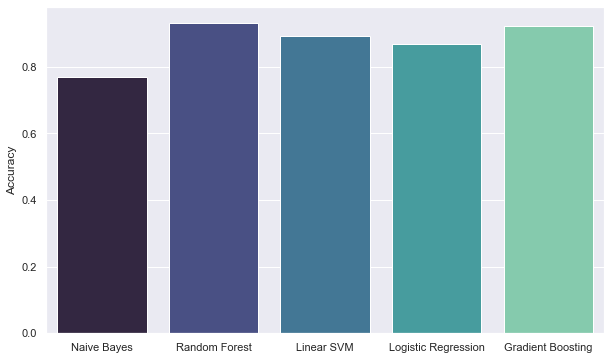

In [18]:
#Accuracy
g = seaborn.barplot(modelList,accuracyList, palette="mako", data= tips)
plt.ylabel("Accuracy")
plt.show(g)

/Users/shubhamgoyanka/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


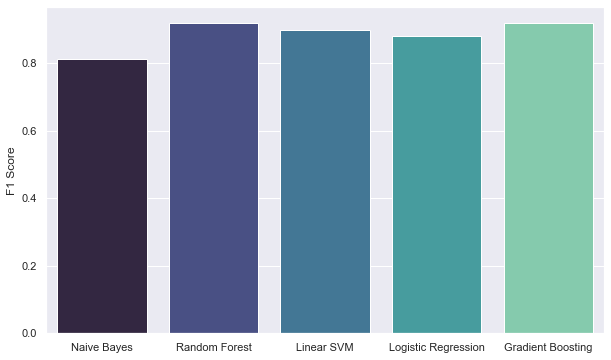

In [19]:
#F1 Score
g = seaborn.barplot(modelList,f1List, palette="mako", data= tips)
plt.ylabel("F1 Score")
plt.show(g)